In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
#import random 
import scipy.integrate as spi
from scipy.integrate import solve_ivp
from scipy import interpolate
from scipy.interpolate import UnivariateSpline
import warnings

In [2]:
%matplotlib inline
#pd.set_option('display.max_rows', None)
#suppress warnings
warnings.filterwarnings('ignore')

All Required Functions:

In [3]:
def ConstructAllData(T):
    p=pd.read_csv(T,delim_whitespace=True)
    df           = pd.DataFrame(p)
    df_OtherHalf = df.rename(columns={'x': 'y','y': 'x'})
    df_1stq=df.append(df_OtherHalf)
    df_2ndq=df_1stq.copy()
    df_2ndq.x=df_2ndq.x*-1
    df_3rdq=df_2ndq.copy()
    df_3rdq.y=df_3rdq.y*-1
    df_4thq=df_1stq.copy()
    df_4thq.y=df_4thq.y*-1
    df_Final=pd.concat([df_1stq, df_2ndq, df_3rdq,df_4thq],ignore_index=True)
    df_Final
    return df_Final

In [4]:
Quad="MagneticFieldFromQuad_ABSMagnetSystemGrid_v2Exact.txt"
SIM="MagneticFieldFromShim_ABSMagnetSystemGrid_v2Exact.txt"
Ring="MagneticFieldFromRing_ABSMagnetSystemGrid_v2Exact.txt"

In [5]:
T_Quad=ConstructAllData(Quad)
T_Quad=T_Quad.dropna()
T_Quad=T_Quad.reset_index(drop=True)

In [6]:
T_SIM=ConstructAllData(SIM)
T_SIM=T_SIM.dropna()
T_SIM=T_SIM.reset_index(drop=True)

In [7]:
pr=pd.read_csv(Ring,delim_whitespace=True)
T_Ring1 = pd.DataFrame(pr)
T_Ring=T_Ring1.dropna()
T_Ring=T_Ring.reset_index(drop=True)

In [8]:
T_Ring["r"]=T_Ring["r"]*100
T_Ring["z"]=T_Ring["z"]*100
T_Ring=T_Ring.round(4)
T_Ring.duplicated().any()

False

In [9]:
T_Quad["x"]=T_Quad["x"]*100
T_Quad["y"]=T_Quad["y"]*100
T_Quad["z"]=T_Quad["z"]*100
T_Quad=T_Quad.round(4)
T_Ring.duplicated().any()
T_Quad

,x,y,z,Bx,By,Bz
0,0.01,0.01,50.0,99.4383,-99.4383,0.0000
1,0.11,0.01,50.0,1093.8294,-99.4368,0.0050
2,0.21,0.01,50.0,2087.9064,-99.3395,0.0074
3,0.31,0.01,50.0,3080.5071,-99.0166,0.0216
4,0.41,0.01,50.0,4068.5898,-98.4716,0.0451
...,...,...,...,...,...,...
10363299,6.91,-6.91,100.0,-0.3732,0.3732,0.0000
10363300,6.91,-7.01,100.0,-0.3774,0.3731,0.0002
10363301,7.01,-6.81,100.0,-0.3690,0.3777,-0.0004
10363302,7.01,-6.91,100.0,-0.3733,0.3776,-0.0002


In [10]:
T_SIM["x"]=T_SIM["x"]*100
T_SIM["y"]=T_SIM["y"]*100
T_SIM["z"]=T_SIM["z"]*100
T_SIM=T_SIM.round(4)
T_SIM

,x,y,z,Bx,By,Bz
0,0.01,0.01,50.0,13.5581,-13.5581,-0.0000
1,0.11,0.01,50.0,149.8987,-13.9302,2.9935
2,0.21,0.01,50.0,285.8187,-13.3832,9.9418
3,0.31,0.01,50.0,421.5557,-13.6647,21.5761
4,0.41,0.01,50.0,557.2836,-13.9302,38.1895
...,...,...,...,...,...,...
10353851,6.91,-6.81,100.0,-13.4563,13.6282,-0.0129
10353852,6.91,-6.91,100.0,-13.6236,13.6236,0.0000
10353853,6.91,-7.01,100.0,-13.8507,13.6809,-0.0578
10353854,7.01,-6.91,100.0,-13.6282,13.8002,-0.0129


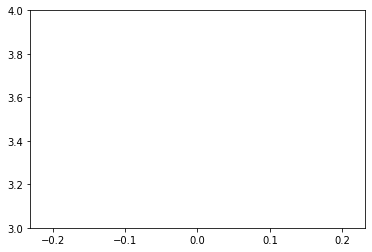

In [11]:
#df1 = T_Quad.loc[(T_SIM['x'] == 0.61) & (T_SIM['y'] == 0.61)&(T_SIM['z'] > 75)]
df1 = T_SIM.loc[(T_SIM['z'] ==62.5)&(abs(T_SIM['x']) < 0.25)]

df2 = T_Quad.loc[(T_Quad['z']==62.5)&(abs(T_Quad['x'])<0.1)&(abs(T_Quad['y'])<1.01)]

df2=df2.round(3)
df1=df1.round(3)
#df2 = df1.loc[df1['y'] == 0.61]
plt.ylim(3,4)
plt.scatter(df1["x"],df1["Bz"], color='r')
plt.scatter(df2["x"],(df2["Bx"]**2+df2["By"]**2+df2["Bz"]**2)**0.5, color='r')

plt.show()

In [12]:
def ObtainB0_Ring(x,T_Ring):
    rt=(x[0]**2+x[1]**2)**0.5
    T_Ring["Del"]=((T_Ring["r"]-rt)**2+(T_Ring["z"]-x[2])**2)**0.5
    b=T_Ring["Del"].idxmin()
    a=T_Ring["Del"].min()
    if a>1.05:
        print("Not working as expected in Ring")
    Theta=math.atan2(x[1],x[0])
    Br=T_Ring.iloc[b]["Br"]
    Bz=T_Ring.iloc[b]["Bz"]
    B=[Br*np.cos(Theta),Br*np.sin(Theta),Bz]
    return B

In [13]:
def ObtainB0(x,T):
    T["Del"]=((T["x"]-x[0])**2+(T["y"]-x[1])**2+(T["z"]-x[2])**2)**0.5
    b=T["Del"].idxmin()
    a=T["Del"].min()
    if a>1.1:
        print("Not working as expected in Quad /SIM ")
    B_Q=[T.iloc[b]["Bx"],T.iloc[b]["By"],T.iloc[b]["Bz"]]
    return B_Q

In [14]:
x=[0.01,0.01,62.5]

In [15]:
def CombineB0(x,T_Quad,T_SIM,T_Ring):
    BQ=ObtainB0(x,T_Quad)
    BS=ObtainB0(x,T_SIM)
    BR=ObtainB0_Ring(x,T_Ring)
    BT=[BQ[0]+BS[0]+BR[0],BQ[1]+BS[1]+BR[1],BQ[2]+BS[2]+BR[2]]
    test=[BQ[0]+BR[0],BQ[1]+BR[1],BQ[2]+BR[2]]
    return BT
    #return test

In [16]:
CombineB0(x,T_Quad,T_SIM, T_Ring)

[114.7780653282912, -114.79093467170881, 10.2128]

In [17]:
#start work to calculate polarization
#intial parameters
g=20378.9; v3=22000;
z0=62.5;#initial position before exit of the quad
#z0=50;#try new one
r0=0.629;
z1=100;
r1=0.7;
num_points=100;
div=15e-3 #15 mrad for ABS 
#div=(r1+r0)/(z1-z0);

Pol=[]; 

finished event :
1 0.9902659871295766
finished event :
2 0.9986054062759685
finished event :
3 0.9945982827628619
finished event :
4 0.9988912150175424
finished event :
5 0.9968111698757043
finished event :
6 0.986573545781544
finished event :
7 0.9871571288597666
finished event :
8 0.9977484374412074
finished event :
9 0.9972221209993659
finished event :
10 0.9999186153962613
finished event :
11 0.974746870210939
finished event :
12 0.9998018737216383
finished event :
13 0.9965522443046668
finished event :
14 0.9998192486596725
finished event :
15 0.9996480243765566
finished event :
16 0.9905769077844321
finished event :
17 0.9855259268107901
finished event :
18 0.9987171752432006
finished event :
19 0.9699904788137869
finished event :
20 0.983920104256258
finished event :
21 0.9989041007530123
finished event :
22 0.999622601548162
finished event :
23 0.9941473300040796
finished event :
24 0.9933450686530471
finished event :
25 0.9956960954396902
finished event :
26 0.9942617933004716

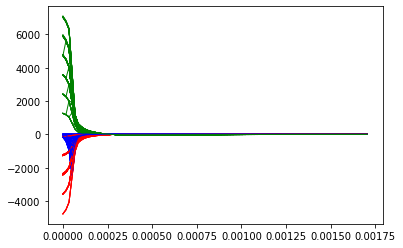

In [18]:
for n in range (1,num_points):
    
    phi = np.random.uniform(0,2*np.pi)
    #rho=-99;
    #while (abs(rho)>0.629):
    #    rho = np.random.normal(loc = 0, scale = 0.25, size = 1)*r0
    rho=np.sqrt(np.random.uniform(0,1))*r0
    x0=[ rho*np.cos(phi), rho*np.sin(phi), z0 ];
    
    B0=CombineB0(x0,T_Quad,T_SIM,T_Ring);
    #obtain norm of the magnetic field
    B0t=np.linalg.norm(B0,axis=0);
    
    r=99999; 
    #make sure the generated values are within the radius of the pipe.
    while(r>r1):  
        ctheta=1-(1-np.cos(div))*np.random.uniform(0,1);
        v1=(v3*math.sqrt(1-pow(ctheta,2))*np.cos(phi), v3*math.sqrt(1-pow(ctheta,2))*np.sin(phi), v3*ctheta );
        #v1=(0,0,v3);
        x1=np.array(x0)
        v=np.array(v1)
        t1=(z1-z0)/v[2];
        x1=x0+(v*t1);
        #r=3;
        r2 = np.sqrt(x0[0]*x0[0] + x0[1]*x0[1]);
        r = np.sqrt(x1[0]*x1[0] + x1[1]*x1[1]);
    B1=CombineB0(x1,T_Quad,T_SIM,T_Ring);
    B1t = np.linalg.norm(B1,axis=0);
   
    #print(x1)
    #plt.scatter(B1[0],x1[1])
    t_i=0
    #print(t1)
    initial_int=0;
    final_int=101;
    B1x=[];
    B1y=[];
    B1z=[];
    T_i=[];
    for t in range (initial_int, final_int,1):
        step=t1/(final_int-initial_int-1) #difference time /difference in range
        ti=t*step
        x_i=x0+(v*ti)
        B_i=CombineB0(x_i,T_Quad,T_SIM,T_Ring);
        #print(B_i,x_i[2])
        T_i.append(ti)
        B1x.append(B_i[0])
        B1y.append(B_i[1])
        B1z.append(B_i[2])
    spl1 = UnivariateSpline(T_i,B1x,k=1)
    spl2 = UnivariateSpline(T_i,B1y,k=1)
    spl3 = UnivariateSpline(T_i,B1z,k=1)
    
    #plt.ylim([-5, 5])
    spl1.set_smoothing_factor(1e-5)
    spl2.set_smoothing_factor(1e-5)
    spl3.set_smoothing_factor(1e-5)
    
    plt.plot(T_i, (spl2(T_i)), 'r', lw = 1)
    plt.plot(T_i, (spl3(T_i)), 'b', lw = 1)
    plt.plot(T_i, (spl1(T_i)), 'g', lw = 1)
    
    #Now solve the differential equation
    
    #sol = solve_ivp(lambda t, y: g*np.cross(y,  CombineCorrespondingMagneticField(x0,v,t,T_Quad,T_SIM,T_Ring)), [0,t1], B0/B0t, method="RK45", rtol = 1e-5)
    sol = solve_ivp(lambda t, y: g*np.cross(y, [spl1(t),spl2(t),spl3(t)]), [0,t1], B0/B0t, method="RK45", rtol = 1e-5)
      
    #obtain last elemet of the array from the ode solution
    Mx=sol.y[0][-1]
    My=sol.y[1][-1]
    Mz=sol.y[2][-1]
    #norm of output vector of the ode
    Mn=np.sqrt(Mx**2+My**2+Mz**2)
    
    #polarization is given by 
    pol=(B1[0]*Mx+B1[1]*My+B1[2]*Mz)/(Mn*B1t)
    Pol.append(pol)
    print("finished event :")
    print(n,pol)

<function matplotlib.pyplot.show(close=None, block=None)>

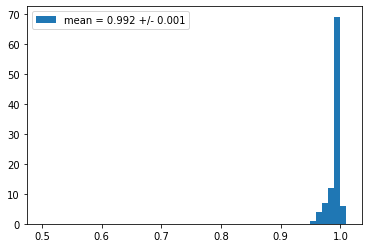

In [23]:
plt.hist(Pol,50,range=[0.5,1.01]);
#plt.ylim([0, 130])
plt.legend(["mean = "+str("{:.3f}".format(np.mean(Pol)))+" +/- "+str("{:.3f}".format(np.std(Pol)/np.sqrt(num_points))) ] )
plt.show